# Tutorial Part 2: mapping multiple phases in a sample pixel-by-pixel

At the end of the first tutorial Tuto_001, we obtained a paired peakfile, with a new column of labels "fp_id" to identify each friedel pair. We saw how to use Friedel pairs to correct the scattering angle and relocate peak sources in the sample. We quickly saw how relocating could be used to obtain an image reconstruction of the scanned slice from the diffraction peaks, either for the full set of paks or from a subset selected by phase. However, the resulting map for a phase subset was not quite satisfactory.

The main issue with phase mapping in complex samples like natural rocks is the overlap of scattering angle between different Bragg peaks from different phases. This results in some ambiguities in peak-to-phase assignment, when a peak can match with several different phases. In this second tutorial, we will see how to improve this, using a pixel-based mapping approach. 

We assume here that we already know what are the different crystallographic phases in our sample, and we already have crystal structure files (cif files). 
This may not be the case in general. Crystal structures from cif files collected in an online database may have been measured at different P-T conditions, or on crystals of slighly different composition, hence not matching perfectly with our data. It is also possible that some or all of the phases in the sample are unknown, and need to be identified beforehand. 

A brief strategy of how to identify / refine unknown crystal structures from the 3DXRD data is described in the previous tutorial, but so far there is not dedicated notebook to do that. Maybe in the future?  

***

### Load packages

In [96]:
# general modules
import os, sys, glob
import h5py
import pylab as pl
import numpy as np
from concurrent.futures import ProcessPoolExecutor
import multiprocessing
from tqdm import tqdm

# ImageD11 https://github.com/FABLE-3DXRD/ImageD11
import ImageD11.sinograms.dataset
import ImageD11.columnfile
import ImageD11.parameters


# point-fit 3dxrd module available at https://github.com/jbjacob94/pf_3dxrd.
# Not yet installable with pip, just copy + paste the files into your working folder 
if '/home/esrf/jean1994b/' not in sys.path:
    sys.path.append('/home/esrf/jean1994b/')    

from pf_3dxrd import utils, friedel_pairs, pixelmap, crystal_structure, peak_mapping, phase_mapping

%load_ext autoreload
%autoreload 2
%matplotlib ipympl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load data & crystal structures

First we need to load the peakfile with paired peaks, that we previously computed in the first tutorial. This file should end with *_pks_p.h5. If not just modify the path in the loading function.

In [97]:
def load_data(dsname, parfile):
    
    # paths
    pksfile = os.path.join(data_dir, dsname+'_pks_p.h5')
    dsfile  = pksfile.replace('pks_p','dataset')
    
    # load ds file and peak file
    ds = ImageD11.sinograms.dataset.load(dsfile)
    print(f'Loading data for dataset {ds.dsname}: \n==============================')    
    items = 'n_ystep,n_ostep,ymin,ymax,ystep,omin,omax,ostep'.split(',')
    vals  = [ds.shape[0], ds.shape[1], ds.ymin, ds.ymax, ds.ystep, ds.omin, ds.omax, ds.ostep]
    for i,j in zip(items, vals):
        print(f'{i}: {j:.2f}')
        
    print('==============================')
    
    
    cf = ImageD11.columnfile.columnfile(pksfile)
    cf.parameters.loadparameters(parfile)
    cf.updateGeometry()
    
    # update tth, etc. using Friedel pairs. 
    friedel_pairs.update_geometry_s3dxrd(cf, ds, update_gvecs=True)

    
    print('\n loaded peakfile: \nnrows =', cf.nrows)
    utils.get_colf_size(cf)
    
    return cf, ds


In [98]:
# paths
data_dir = 'data'
dsname = 'SI3_DT360Z5480'
parfile='data/SI3.par'

In [99]:
# load data
cf, ds = load_data(dsname, parfile)

Loading data for dataset SI3_DT360Z5480: 
n_ystep: 109.00
n_ostep: 450.00
ymin: -2.70
ymax: 2.70
ystep: 0.05
omin: 0.00
omax: 360.00
ostep: 0.80
Reading your columnfile in hdf format

 loaded peakfile: 
nrows = 2870632
Total size =  251.87 MB


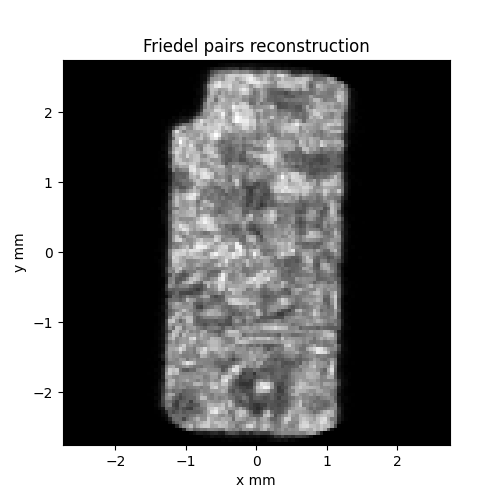

In [100]:
# plot sample reconstruction to check it is ok
kw = {'cmap':'Greys_r', 'vmin':0.01, 'vmax':0.9}
utils.friedel_recon(cf, ds.ybinedges, ds.ybinedges, norm=True, doplot=True, mask = None, **kw);

We need to load crystal structures as well. We will use the CS class from crystal_structure.py introduced in the previous tutorial.

In [101]:
# load crystal structures and store them in a dictionnary
pnames = ['quartz', 'magnetite', 'biotite', 'orthoclase', 'oligoclase'] # cif files should be named '<phase_name>.cif'
phase_dict = {name: crystal_structure.load_CS_from_cif(cif_path = f'cif/{name}.cif', name=name, pid = i) for i,name in enumerate(pnames)}

for cs in phase_dict.values():
    print(cs)


CS: quartz, phase_id: 0, spg: P3221, spg_no: 154, lattice: [  4.91325   4.91325   5.41206  90.       90.      120.     ]
CS: magnetite, phase_id: 1, spg: Fd3m, spg_no: 227, lattice: [ 8.3965  8.3965  8.3965 90.     90.     90.    ]
CS: biotite, phase_id: 2, spg: C12/m1, spg_no: 12, lattice: [  5.355   9.251  10.246  90.    100.15   90.   ]
CS: orthoclase, phase_id: 3, spg: C1-11, spg_no: 12, lattice: [  8.589  13.013   7.197  90.    116.02   90.   ]
CS: oligoclase, phase_id: 4, spg: C-1, spg_no: 2, lattice: [  8.154  12.823   7.139  94.06  116.5    88.59 ]


### Create a 2D pixel grid with Pixelmap

Phase mapping is done on a 2D grid of pixels, whose size is given by the scanning range along the y-axis, and the resolution by the y-step size. To make things more convenient, a new class "Pixelmap" is introduced, from the module pixelmap.py. It creates a "pixelmap" (xmap) object, which allows to map properties on a fixed 2D grid. This class has many functionalities, which we will explore in this tutorial and the following ones. From now on, it is the main object on which we will work, in addition to ImageD11 columnfiles. 

First, we need to initialize the pixelmap. For this, we need to define a grid.

In [102]:
# Initialize pixelmap grid
xb = yb = np.arange(len(ds.ybinedges)) # bins
xmap = pixelmap.Pixelmap(xb, yb, h5name = os.path.join(data_dir, ds.dsname+'_xmap.h5'))
xmap.grid.pixel_size = ds.ystep * 1000   # with the frelon detector ystep is given in mm; converti it to µm
xmap.grid.pixel_unit = 'µm'

print(xmap)
print(xmap.grid)

for t in xmap.titles():
    print(t, xmap.get(t).shape)

Pixelmap:
 size: (110, 110),
 phases: ['notIndexed'],
 phase_ids: [-1],
 titles: ['xyi', 'xi', 'yi', 'phase_id', 'grain_id'], 
 grains: 0
grid: size: (110, 110), pixel size: 50.0 µm
xyi (12100,)
xi (12100,)
yi (12100,)
phase_id (12100,)
grain_id (12100,)


The pixelmap contains data arrays, as well as different sub-classes to store information on the grid, grains, and the crystal structure of each phase. The pixelmap contains sub-class objects 'phases', 'grid' and 'grains', containing respectively information on crystal structures, pixel grid and indexed grains.

Here the map is defined on a 110x110 pixel grid (ie. 12100 pixels), with a pixel size of 50µm. Data columns are ndarrays of length (N,M), where N = nx.ny. Some columns have been defined during initialization, namely pixel index xi, yi, xyi, phase_id and grain_id. Let's have a look. 

In [103]:
# have a look on a subset of xi, yi and xyi arrays
for t in ['xi','yi','xyi']:
    print(f'{t} : {xmap.get(t)[120:130:2]}')

# xi and yi can be easily retrived from xyi:
print(f'xyi%10000:{xmap.xyi[120:130:2]%10000}')
print(f'xyi//10000:{xmap.xyi[120:130:2]//10000}')

xi : [10 12 14 16 18]
yi : [1 1 1 1 1]
xyi : [10010 10012 10014 10016 10018]
xyi%10000:[10 12 14 16 18]
xyi//10000:[1 1 1 1 1]


xi and yi correspond to pixel position in x and y respectively. xyi is a unique index built using these two coordinates: xyi = xi + 10000.yi. This index is unique to each pixel as long as the map is less than 10000 px wide, which will normally be the case. It allows rapid search of pixels by index in a unique list instead of two, while preserving pixel coordinates information.

phase_id and grain_id are arrays of index values relating each pixel on the map to a phase / grain. Since nothing has been indexed yet, they only contain -1 values.

In [104]:
print(f'{xmap.phase_id=:} {xmap.phase_id.shape:}')
print(f'{xmap.grain_id=:} {xmap.grain_id.shape:}')

xmap.phase_id=[-1 -1 -1 ... -1 -1 -1] (12100,)
xmap.grain_id=[-1 -1 -1 ... -1 -1 -1] (12100,)


In [105]:
#NB there is also a function to do initilize xmap directly from a dataset object
xmap = pixelmap.create_from_dataset(ds, h5name = os.path.join(data_dir, ds.dsname+'_xmap.h5') )
print(xmap)

Pixelmap:
 size: (110, 110),
 phases: ['notIndexed'],
 phase_ids: [-1],
 titles: ['xyi', 'xi', 'yi', 'phase_id', 'grain_id'], 
 grains: 0


So far, only the grid has been initialized. Now, let's add phases.

In [106]:
# Add phases from phase_dict
for phasename, cs in phase_dict.items():
    xmap.phases.add_phase(phasename, cs)
    
# print some information about pixelmap
print(xmap,'\n-------')
print(xmap.grid,'\n-------')
print(xmap.phases)

for p in xmap.phases.pnames: 
    print(xmap.phases.get(p))

Pixelmap:
 size: (110, 110),
 phases: ['notIndexed', 'quartz', 'magnetite', 'biotite', 'orthoclase', 'oligoclase'],
 phase_ids: [-1, 0, 1, 2, 3, 4],
 titles: ['xyi', 'xi', 'yi', 'phase_id', 'grain_id'], 
 grains: 0 
-------
grid: size: (110, 110), pixel size: 50.0 µm 
-------
phases: ['notIndexed', 'quartz', 'magnetite', 'biotite', 'orthoclase', 'oligoclase']
CS: notIndexed, phase_id: -1, spg: None, spg_no: None, lattice: []
CS: quartz, phase_id: 0, spg: P3221, spg_no: 154, lattice: [  4.91325   4.91325   5.41206  90.       90.      120.     ]
CS: magnetite, phase_id: 1, spg: Fd3m, spg_no: 227, lattice: [ 8.3965  8.3965  8.3965 90.     90.     90.    ]
CS: biotite, phase_id: 2, spg: C12/m1, spg_no: 12, lattice: [  5.355   9.251  10.246  90.    100.15   90.   ]
CS: orthoclase, phase_id: 3, spg: C1-11, spg_no: 12, lattice: [  8.589  13.013   7.197  90.    116.02   90.   ]
CS: oligoclase, phase_id: 4, spg: C-1, spg_no: 2, lattice: [  8.154  12.823   7.139  94.06  116.5    88.59 ]


For each phase, a CS object is attached, accessible at xmap.phases.phase_name or using the method xmap.phases.get('phase_name'). The list of all phase names and phase indexes is accessible in xmap.phases.pnames and xmap.phases.pids

In [107]:
xmap.phases.pnames, xmap.phases.pids

(['notIndexed', 'quartz', 'magnetite', 'biotite', 'orthoclase', 'oligoclase'],
 [-1, 0, 1, 2, 3, 4])

### Map phases pixel-by-pixel with PhaseMapper

Now we have a peakfile cf containing peaks, a list of cystal phases in phase_dict, and a 2D map xmap on which phases will be mapped. We want to use diffraction peaks in the peak file to find the best-matching phase (among the list provided) for each pixel of the map. This is done using the class PhaseMapper from phase_mapping.py, which contains different methods to perform phase labeling.

First we need to initialize a new PhaseMapper object, using our columnfile, pixelmap and list of crystal structures. 

In [108]:
# PhaseMapper object to map peaks to pixel and find best phase match on the 2D grid
PhaseMapper = phase_mapping.PhaseMapper(cf, ds, xmap, CS_list=phase_dict.values())

print('================= \n',PhaseMapper)

no xyi column in peakfile. Adding pixel index...
sorting by two-theta...
rescaling intensity...
 PhaseMapper:
 peaks to map:2870632
 phases: ['quartz', 'magnetite', 'biotite', 'orthoclase', 'oligoclase']
 phase_ids:[0, 1, 2, 3, 4]
 grid: size: (110, 110), pixel size: 50.0 µm
 minpks: 50
 min_confidence: 0.1
 kernel_size: 1


In [109]:
# NB: since we already added phases to xmap, it is possible to pass these directly to PhaseMapper
PhaseMapper = phase_mapping.PhaseMapper(cf, ds, xmap)
PhaseMapper.add_phases_from_pixelmap()

print('================= \n',PhaseMapper)

sorting by two-theta...
rescaling intensity...
 PhaseMapper:
 peaks to map:2870632
 phases: ['quartz', 'magnetite', 'biotite', 'orthoclase', 'oligoclase']
 phase_ids:[0, 1, 2, 3, 4]
 grid: size: (110, 110), pixel size: 50.0 µm
 minpks: 50
 min_confidence: 0.1
 kernel_size: 1


#### phase labeling strategy
Phase labeling consists in assigning a phase label (corresponding to one of the pre-selected crystal structures in the list) to each peak in the peakfile, and to each pixel on the 2D map. The strategy employed involves two steps:

First, Boolean selection masks are computed for each phase, which select peaks based on a 2-theta threshold around each theoretical Bragg peak of a given phase. For instance, if a phase has Bragg peaks at 2-theta angles 3°, 5° and 8° and a 2-theta threshold of 0.1° is used, every peaks within two theta ranges [2.9-3.1], [4.9-5.1] and [7.9-8.1] will be selected. At this stage, overlaps can exist and a peak can belong to several selection masks of different phases, if it lies within an interval where multiple phase masks overlap. 

Second, a pixel-by-pixel procedure is run, to find the best phase match over each pixel. Basically, all peaks arising from a pixel are selected. Using pre-computed phase selection masks, the best-matching phase is found for this pixel, and some completeness and uniqueness criterions are computed to evaluate the phase-match quality. If the match is above a certain threshold, a phase label is assigned to the pixel and to the peaks arising from this pixel. Doing this at the pixel level allows to much better handling of overlap conflicts that simple 2-theta threshold selections.  

#### raw phase masks
First we need to compute the 2-theta selection masks for each phase. We don't have yet the position of theoretical Bragg peaks for each phase, so we need to compute them. This is done with the method find_strongest_bragg_peaks below, and illustrated with quartz.

The method takes a crystal structure in input and simulates the diffraction spectrum over a given 2-theta range. Then, a peaksearch is using scipy.signal to find the strongest peaks on this spectrum. This list of peaks and corresponding intensity are added to phasemapper.phases.[phasename]

Imin and prominence are parameters used in peaksearch to decide each local maxima are considered as peaks. see scipy.signal documentation for more details. Nmax is the maximum number of peaks returned. The outputs from peaksearch are sorted by decreasing intensity, and the N-strongest peaks are returned.

Scatter(quartz with 2 atomic positions, 6 symmetries)
       Type: x-ray
     Energy: 43.57356018082551 keV
 Wavelength: 0.28454050670689945 A
 ---Settings---
      Powder units: tth
    Isotropic ADPs: True
  Specular Direction (reflection): ( 0, 0, 1)
Parallel Direction (transmission): ( 0, 0, 1)
      theta offset: 0.0
         min theta: -180.0
         max theta: 180.0
      min twotheta: 0
      max twotheta: 15
 ---X-Ray Settings---
 Waasmaier scattering factor: False
 ---Magnetic Settings---
   Mag. scattering: True
  Mag. form factor: True
         Polarised: False
      Polarisation: sp
       Pol. vector: (0,1,0)
 ---Resonant Settings---
   Azimuthal angle: 0
    Azimuthal ref.: (1,0,0)
               flm: (0,1,0)
  use e1e1 approx.: True



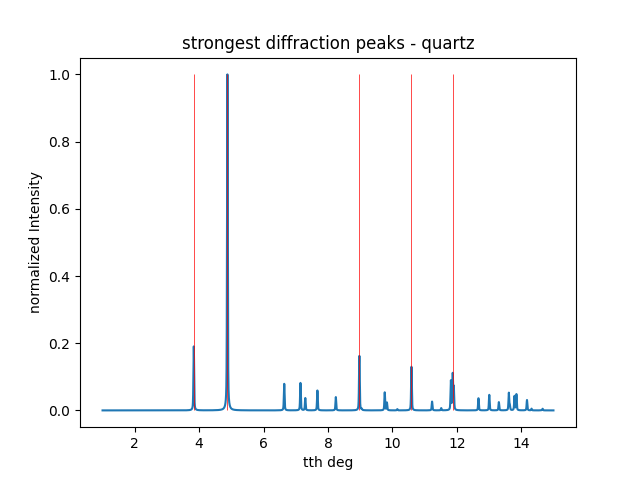

In [110]:
PhaseMapper.find_strongest_bragg_peaks('quartz', min_tth=0, max_tth=15, Nmax=40, Imin=0.1, prominence=0.1, doplot=True)

Imin and prominence threshold for peaksearch were quite high, so just a few peaks have been selected. We can reduce those numbers if we want more peaks.

It is also possible to compute spectras and return Bragg peaks for allphases in PhaseMapper at once, using the method below.

Scatter(quartz with 2 atomic positions, 6 symmetries)
       Type: x-ray
     Energy: 43.57356018082551 keV
 Wavelength: 0.28454050670689945 A
 ---Settings---
      Powder units: tth
    Isotropic ADPs: True
  Specular Direction (reflection): ( 0, 0, 1)
Parallel Direction (transmission): ( 0, 0, 1)
      theta offset: 0.0
         min theta: -180.0
         max theta: 180.0
      min twotheta: 0
      max twotheta: 15
 ---X-Ray Settings---
 Waasmaier scattering factor: False
 ---Magnetic Settings---
   Mag. scattering: True
  Mag. form factor: True
         Polarised: False
      Polarisation: sp
       Pol. vector: (0,1,0)
 ---Resonant Settings---
   Azimuthal angle: 0
    Azimuthal ref.: (1,0,0)
               flm: (0,1,0)
  use e1e1 approx.: True

Scatter(magnetite with 3 atomic positions, 192 symmetries)
       Type: x-ray
     Energy: 43.57356018082551 keV
 Wavelength: 0.28454050670689945 A
 ---Settings---
      Powder units: tth
    Isotropic ADPs: True
  Specular Direction (refl

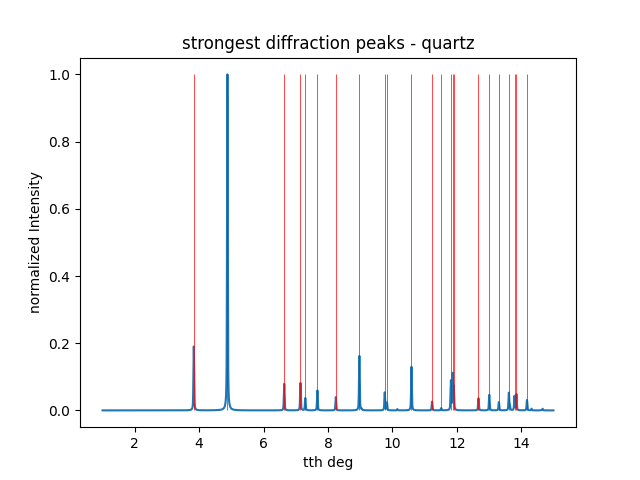

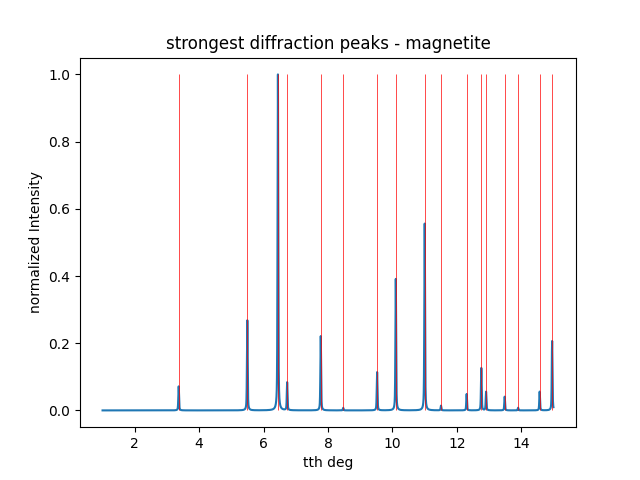

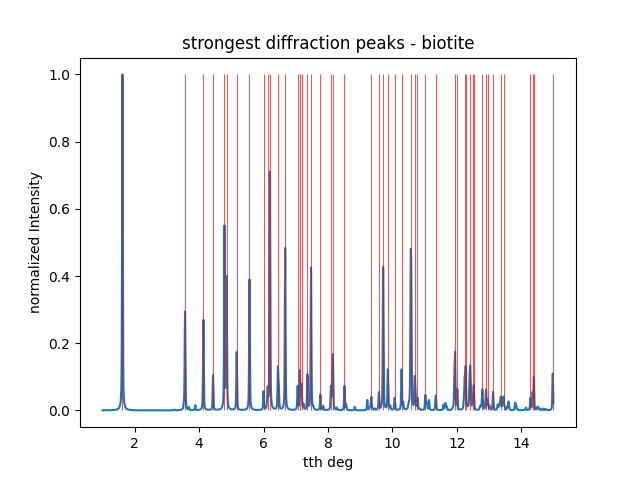

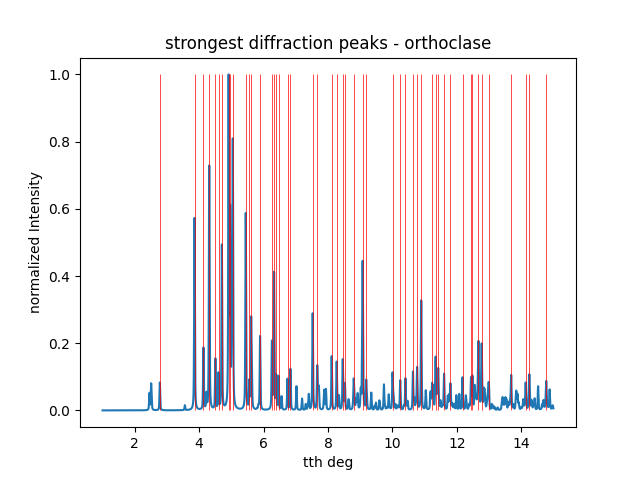

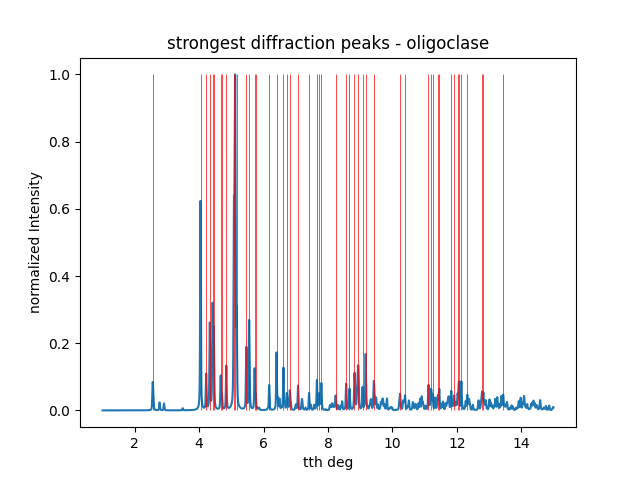

In [111]:
PhaseMapper.find_strongest_bragg_peaks_all(0, 15, Nmax=50, Imin=0.005, prominence=0.005, doplot=True) 

Now theoretical Bragg peaks have been computed, we can compute phase selection masks, using the method below. tthmax gives the maximum 2-theta threshold (cut the largest scattering angles) and tth_tol is the size of the threshold (in degree) around each Bragg peaks.

The proportion of peaks selected in each mask is returned, as well as the total fraction of peaks assigned (selected by at least one phase) and the fraction of peak overlaps (fraction of peaks assigned to more than one phase). 

If we increase the threshold, the proportion of selected peaks will increase as well, but so will do the overlap as well (which is not what we want). The number of theoretical bragg peaks (see above) retained also has an importance, especially in our case, where the sample contains several complex phases with a very large number of theoretical Bragg peaks. If the overlap are too large, reducing Nmax or increasing Imin and prominence for the peaksearch might be a good idea. 

In [112]:
# compute phase masks
PhaseMapper.compute_phase_mask_all(tth_max=15, tth_tol=0.025)

pks fraction quartz: 0.2495
pks fraction magnetite: 0.0652
pks fraction biotite: 0.2284
pks fraction orthoclase: 0.2443
pks fraction oligoclase: 0.2633

Total pks fraction assigned: 0.6945
fraction overlapping: 0.2951


It is always a good idea to plot peaks in a 2-theta vs. eta diagram, to make sure that peaks from most of the main 2-theta rings have been selected, and to see where overlap occurs. There is a method in PhaseMapper for plotting, where peaks are colored by phase masks.

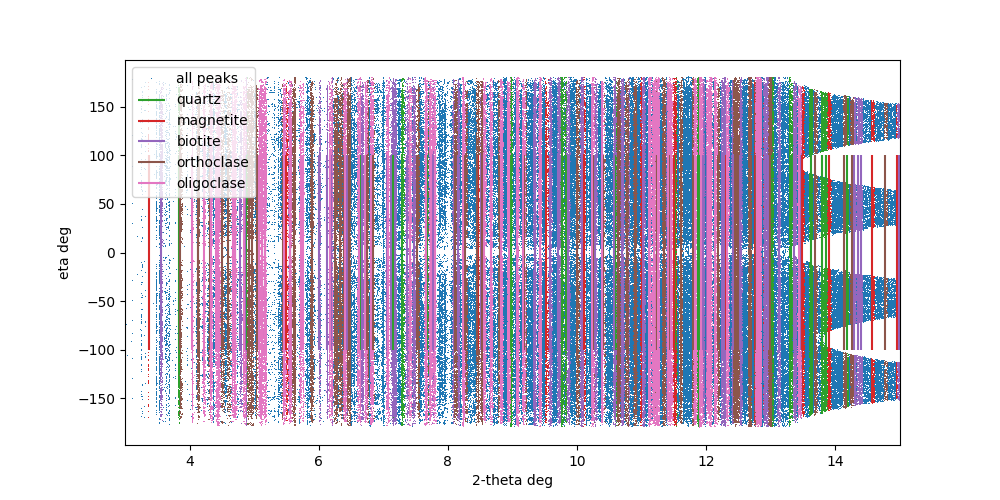

In [113]:
# plot tth vs eta for a subset of peaks to see what the selection looks like
PhaseMapper.plot_tth_eta(min_tth=3, max_tth=15, show_theorytth=True, phase_colors='from_mask')

Plots can also be done using a 2-theta histogram

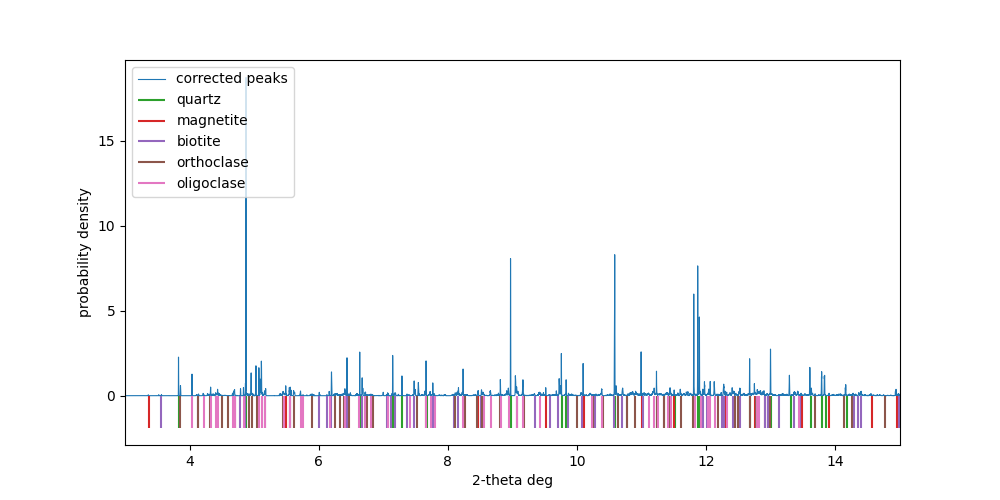

In [114]:
PhaseMapper.plot_tth_histogram(min_tth=3, max_tth=15, tth_step=0.0005,
                               show_non_corrected=False, show_theorytth=True)

#### prepare PhaseMapper
Now pre-selection phase masks have been added. There are several things to set up in Phase Mapper to prepare for phase labeling. 
This includes initialization of the peakfile, and sorting by xyi index. This is done with the function below:

In [115]:
PhaseMapper.prepare_for_phase_labeling()

Ready for phase labeling!


We also need to set up a few parameters in Phase Mapper

In [116]:
PhaseMapper.kernel_size = 3
PhaseMapper.minpks = 800
PhaseMapper.min_confidence = 0.1
PhaseMapper.chunksize = 500
PhaseMapper.ncpu
PhaseMapper.res = {}

- minpks : minimum number of peaks on a pixel, below which it will remain unlabeled
- min_confidence : lower threshold for normalized confidence index, below which pixel will remain unlabeled
- kernel_size : peak selection is done in a $n \times n$ kernel around each pixel. default is n=1 (signel pixel selection), but kernel size can be increased to get a smoother map. If a larger kernel size is used, think of increasing minpks accordingly
- chunksize : size of chunks for multiprocessing
- ncpu : number of cpus used for multiprocessing. Default is the largest number available
- res: dictionnary in which phase labeling outputs are temporarily written

To set up minpks, it can be useful to have an idea of the total number of peaks per pixel. We can plot the distribution to see what threshold we should use. Here, we see that there are two populations of pixels with <200 and >200 peaks. The group of pixels with low peak count probably corresponds to pixels outside the sample, containing dodgy friedel pairs for which relocalization in the sample is inaccurate. A minpks cutoff of 200 seems to be a good guess. However, we also need to account for the fact that only a fraction of peaks per pixel will be selected by each phase, so we need to reduce a bit this value to avoid being too restrictive in the peak selection. We will start at 100.

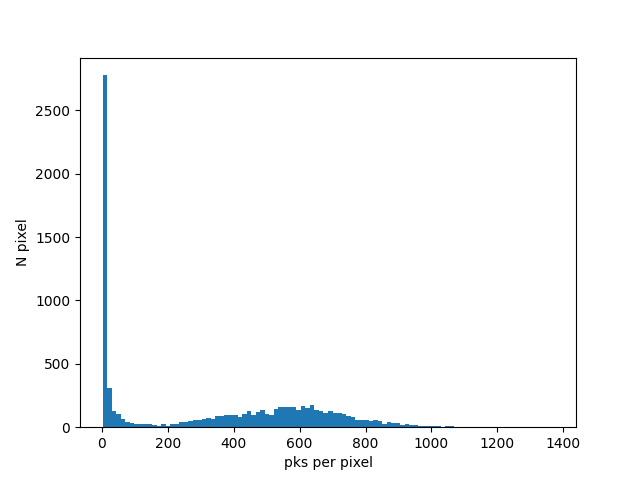

In [117]:
# plot the distribution of peak counts per pixel, to adjust the minpks parameter (below).
def npks_per_pixel_hist(cf):
    px, cnts = np.unique(cf.xyi, return_counts=True)
    pl.figure()
    pl.hist(cnts[cnts>0],100);
    pl.xlabel('pks per pixel')
    pl.ylabel('N pixel')
    
npks_per_pixel_hist(cf)

#### phase labeling
best_phase_match(px) is the core function here. It finds the best-matching phase for the input pixel (xyi index) and returns the hase id, confidence evaluation criteria (completeness, uniqueness, normalized confidence index) as well as the list of peak index in peakfile which should be updated with this phase label.

In [118]:
PhaseMapper.best_phase_match(450045)

(4,
 0.6119157506930717,
 0.5979326822625857,
 0.3078723620976436,
 array([889781, 889784, 889791, 889794, 889796, 889799, 889804, 889805,
        889806, 889807, 889808, 889809, 889811, 889813, 889814, 889816,
        889818, 889819, 889821, 889822, 889823, 889828, 889829, 889830,
        889834, 889835, 889837, 889838, 889840, 889842, 889843, 889844,
        889846, 889854, 889855, 889859, 889862, 889863, 889864, 889865,
        889870, 889872, 889875, 889876, 889877, 889879, 889882, 889883,
        889888, 889889, 889890, 889893, 889897, 889898, 889901, 889904,
        889907, 889908, 889921, 889925, 889926, 889938, 889939, 889940,
        889942, 889943, 889950, 889958, 889967, 889969, 889972, 889975,
        889976, 889979, 889986, 889987, 889988, 889990, 889991, 889998,
        890000, 890004, 890006, 890009, 890010, 890018, 890024, 890028,
        890032, 890033, 890039, 890040, 890041, 890043, 890048, 890055,
        890056, 890061, 890064, 890066, 890078, 890079, 890081, 89008

best_phase_match is quite fast to run, but the whole process can still take quite a bit of time if it is run on a large map. However it is easy to parallelize:

In [119]:
def func_wrapper(px):
    # wrapper to return both the input and the output
    return px, PhaseMapper.best_phase_match(px)

# run phase mapping in parallel and write outputs in PhaseMapper.res (dictionnary)
if __name__ == "__main__":
    with ProcessPoolExecutor() as pool:
        pool.max_workers=max(PhaseMapper.ncpu-1,1)
        pool.mp_context=multiprocessing.get_context('fork')
        
        for px, r in tqdm( pool.map(func_wrapper,
                                PhaseMapper.xyi_uniq,
                                chunksize=PhaseMapper.chunksize) ):
            PhaseMapper.res[px] = r

8503it [00:03, 2478.46it/s]


Results have been written in a dictionnary (PhaseMapper.res). Now we want to unpack these results, to add phase labels to the peakfile and to xmap

In [120]:
# write outputs in pixelmap. peakfile phase_id column is also updated at the same time, giving a phase label to each peak
PhaseMapper.results_to_xmap()

100%|██████████| 8503/8503 [00:00<00:00, 1030012.04it/s]

Pixelmap:
 size: (110, 110),
 phases: ['notIndexed', 'quartz', 'magnetite', 'biotite', 'orthoclase', 'oligoclase'],
 phase_ids: [-1, 0, 1, 2, 3, 4],
 titles: ['xyi', 'xi', 'yi', 'phase_id', 'grain_id', 'Npks', 'phase_label_confidence', 'completeness', 'uniqueness'], 
 grains: 0


We see that new columns have been added, for confidence criteria and number of peaks (Npks). Also, phase_id now contains more values, both in pixelmap and in  peakfile.

In [121]:
print(np.unique(PhaseMapper.pixelmap.phase_id))
print(np.unique(PhaseMapper.peakfile.phase_id))

[-1  0  1  2  3  4]
[-1  0  1  2  3  4]


We can print some statistics about peak labeling

In [122]:
# print some stats about laleled peaks: fraction of peaks assigned to each phase (in proportion of the total number of peaks in peakfile)
PhaseMapper.get_stats_labeled_peaks()

fraction of labeled peaks 
----------
quartz: 0.1380
magnetite: 0.0049
biotite: 0.0643
orthoclase: 0.0476
oligoclase: 0.1087
assigned: 0.3635
fraction of total intensity 
----------
quartz: 0.2647
magnetite: 0.0208
biotite: 0.1154
orthoclase: 0.0567
oligoclase: 0.1484
assigned: 0.6061


We can also compare to the stats in the pre-computed masks. We see that overall, the proportion of peaks assigned to each phase has decreased, because  each overlapping peak had to "choose" one single phase. Also, peaks belonging to weak or unreliable pixels (npks < minpks or conf_ind < min_confidence) have been rejected, reducing overall the proportion of "assigned" peaks. 

In [123]:
PhaseMapper.get_stats_raw_masks()

peak fractions in raw selection masks 
----------
quartz: 0.2495
magnetite: 0.0652
biotite: 0.2284
orthoclase: 0.2443
oligoclase: 0.2633
overlap: 0.2951
assigned: 0.6945
fraction of total intensity in masks 
----------
quartz: 0.3576
magnetite: 0.0627
biotite: 0.3040
orthoclase: 0.2428
oligoclase: 0.3027
overlap: 0.3789
assigned: 0.8273


### Plots
phase id and other properties have been added to pixelmap. Now we can plot 2D maps for each property.
- completeness evaluates the proportion of total intensity matched over each pixel by the best-matching phase. it varies between 0  (not intensity matched) and 1 (100% intesity matched)
- uniqueness eveluates how unique the phase match is. It varies between 0 (100% overlap with over phases) and 1 (0% overlap)
- phase_label_confidence is a  criterion between 0 and 1 buiilt using the two quantities above
- Npks is the number of peaks matched on each pixel.
- phase_id is a label to identify each phase. It is the same as the phase_id defined in xmap.phases.[phasename].phase_id.

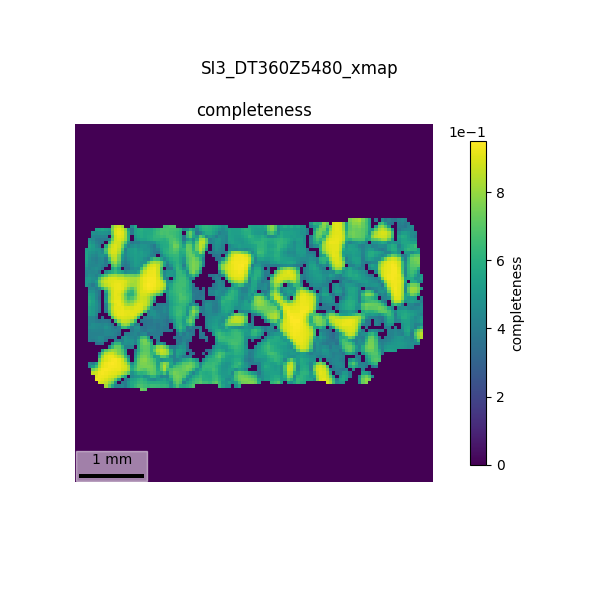

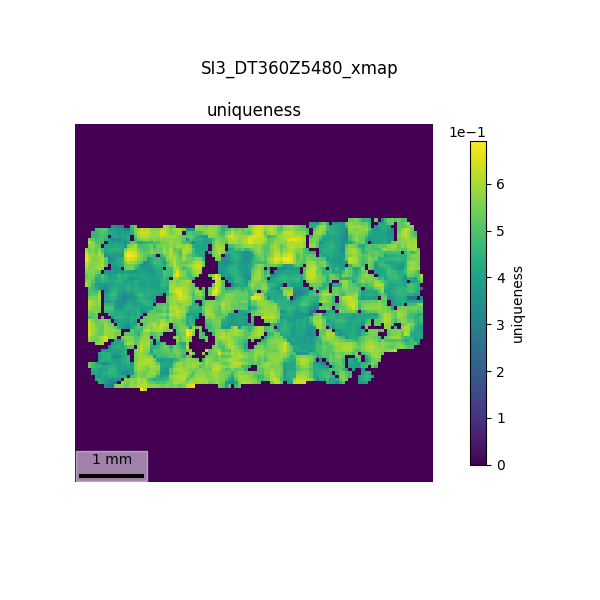

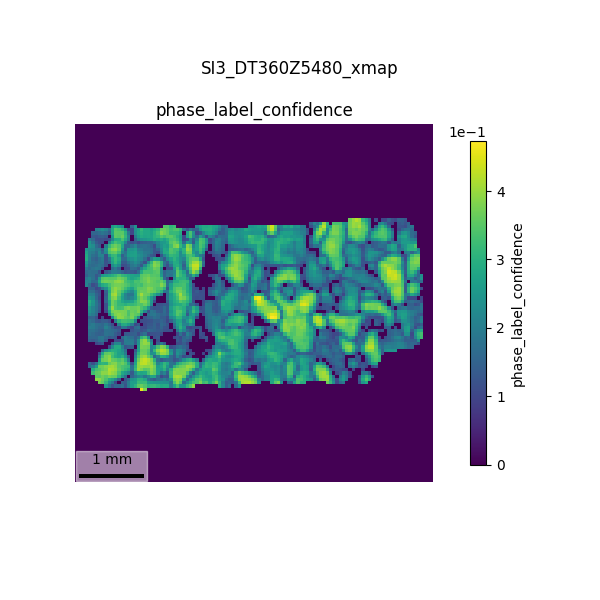

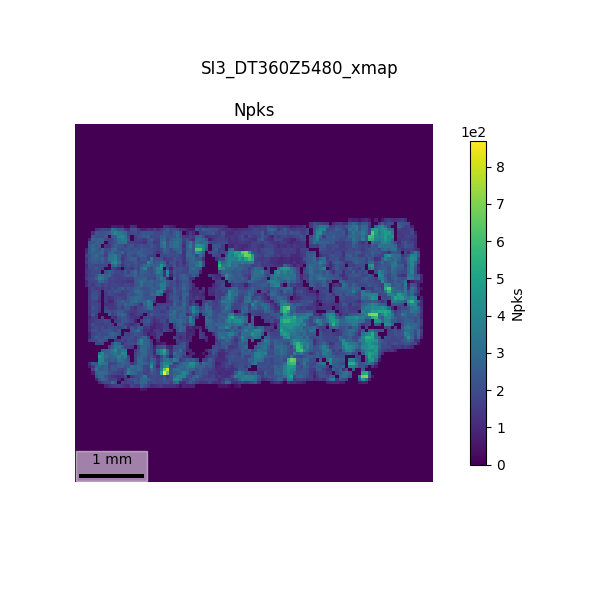

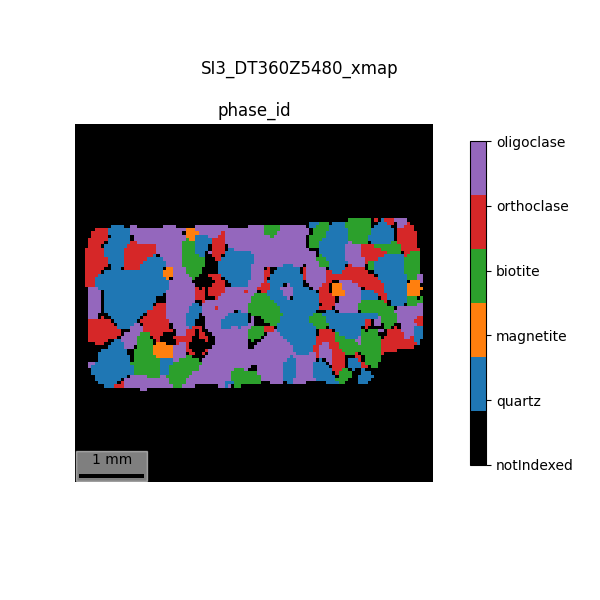

In [124]:
# make some plots and save : phase_id, Ci, Npks
pl.close('all')

colors = ((0,0,0),) + pl.matplotlib.cm.tab10.colors
cmap = pl.matplotlib.colors.ListedColormap( colors[:len(xmap.phases.pnames)] )

save=False
var_to_plot = ['completeness','uniqueness','phase_label_confidence','Npks','phase_id']


for i, var in enumerate(var_to_plot):
    if var == 'phase_id':
        kw = {'cmap':cmap}
        xmap.plot(var, autoscale=False, save=save, **kw)
        
    else:
        kw = {'cmap':'viridis'}
        xmap.plot(var, autoscale=False, percentile_cut=[1, 99], save=save, **kw)


Now you can try to vary some parameters in PhaseMapper and re-do phase mapping. 

Try this for instance:
- increase kerne_size to 3 (do not forget to increase minpks as well, because the selection will naturally include a larger nuber of peaks). This should result in smoother maps
- increase min_confidence. his will clean up the map and remove unreliable domains.
- re-compute phase masks using a larger or lower 2-theta threshold. You can also recompute theoretical Bragg peaks to retain more or less of them, adjust the minimum prominence and intensity, etc. 

For tricky cases, you may need to define 2-theta thresholds and Bragg peak parameters (Nmax, Imin, prominence) on a per-phase basis

### Filter peak file and save outputs

once you are satisfied with the outputs, save the labeled peakfile and the pixelmap. 

In [126]:
# remove phase mask columns in peakfile. we don't need them anymore
columns_to_drop = PhaseMapper.phases.pnames+['overlap','assigned']

cf = ImageD11.columnfile.colfile_from_dict({t:cf.getcolumn(t) for t in cf.titles if t not in columns_to_drop})

In [127]:
# filter out unlabeled peaks (phase_id = -1) 
cf.filter(cf.phase_id != -1)

In [133]:
# sanity check: make sure filtering has not splitted up some friedel pairs. In such case, you would not be able to recompute friedle pair geometric corrections 
# when reloading the peakfile (friedel_pairs.update_geometry_s3dxrd).

fpid = cf.fp_id.copy()
fpid_sorted = np.sort(fpid)

np.all(np.equal(fpid_sorted[::2], fpid_sorted[1::2]))

True

If everything is allright, save labeled peakfile and pixelmap

In [134]:
# save new cf
outname = os.path.join(data_dir,ds.dsname+'_pks_p_flt.h5')  # add 'flt' to filename -> new peakfile with only labeled peaks 
utils.colf_to_hdf(cf, outname, save_mode = 'minimal')

# save pixelmap
xmap.save_to_hdf5()

Pixelmap saved to: data/SI3_DT360Z5480_xmap.h5
